# Open Street Map network partitioning
---

## Imports

In [23]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from itertools import groupby
from operator import itemgetter

%matplotlib inline

In [24]:
G_drive = nx.read_gpickle("pickle/OSM_street_network.gpickle")
G = nx.Graph(G_drive)

# Partitioning the graph into geographical chunks

In [25]:
# get tuple of x/y coordinates

locations = []

for node in G.nodes():
    locations.append(tuple([(G.nodes[node]['lon']), G.nodes[node]['lat']]))

In [26]:
# get min/max coordinates
min_x = min(locations,key=itemgetter(0))[0]
max_x = max(locations,key=itemgetter(0))[0]
min_y = min(locations,key=itemgetter(1))[1]
max_y = max(locations,key=itemgetter(1))[1]

In [27]:
# get corners of rectangle
sw = tuple([min_x, min_y])
nw = tuple([min_x, max_y])
ne = tuple([max_x, max_y])
se = tuple([max_x, min_y])

In [28]:
def getEquidistantPoints(p1, p2, parts):
    return zip(np.linspace(p1[0], p2[0], parts+1),
               np.linspace(p1[1], p2[1], parts+1))

In [29]:
# set at 100 parts for ease of using full alphabet

y = list(getEquidistantPoints((nw), (sw), 100))
x = list(getEquidistantPoints((sw), (se), 100))

ys = [x[1] for x in y]
xs = [x[0] for x in x]

In [30]:
X, Y = np.meshgrid(xs, ys)
grid = zip(X, Y)

In [31]:
# plotting an example grid
plt.figure(figsize=(10,8))
plt.plot(X, Y, marker='+', color='red', linestyle='none');

In [54]:
df = pd.DataFrame()

x_square = (max_x - min_x)/100
y_square = (max_y - min_y)/100

def label_point(x, y):
    # Double forward slash is integer (round down) division
    # Add 1 here if you really want 1-based indexing
    x_label = (x - min_x) // (x_square)
    y_label = chr(255 - int((y - min_y) // y_square))
    return f'{x_label}{y_label}'

In [37]:
x = nw[0]
x

-2.7171539

In [38]:
min_x

-2.7171539

In [39]:
x_square

0.007397247

In [40]:
(x - min_x) // (x_square)

0.0

In [43]:
y = nw[1]
y

53.6643887

In [44]:
min_y

53.3426582

In [45]:
y_square

0.00321730500000001

In [52]:
chr(100 - int((y - min_y) // y_square))

'\x00'

In [55]:
# sense check extremeties
print(label_point(nw[0], nw[1]))
print(label_point(ne[0], ne[1]))
print(label_point(sw[0], sw[1]))
print(label_point(se[0], se[1]))

0.0
100.0
0.0ÿ
100.0ÿ


In [17]:
xx = []
for i in locations:
    xx.append(i[0])
    
yy = []
for i in locations:
    yy.append(i[1])

In [18]:
df['x'] = xx
df['y'] = yy

In [19]:
df['label'] = df[['x', 'y']].apply(lambda coord: label_point(*coord), axis=1)

In [20]:
df

x          y  label
0     -2.552090  53.494095   5.0N
1     -2.637079  53.558678   2.0I
2     -2.541474  53.479011   6.0O
3     -2.133602  53.379638  20.0X
4     -2.134236  53.378917  20.0X
...         ...        ...    ...
96248 -2.327129  53.369216  13.0X
96249 -2.134148  53.379133  20.0X
96250 -2.142255  53.523432  20.0L
96251 -2.134107  53.379268  20.0X
96252 -2.134252  53.379294  20.0X

[96253 rows x 3 columns]

In [21]:
res = dict(zip(list(G.nodes()), df['label']))

In [22]:
nx.set_node_attributes(G, res, "sub_graph")

In [23]:
locations = dict(zip(list(G.nodes()), locations))
nx.set_node_attributes(G, locations, 'pos')

In [24]:
grid_refs = sorted(df['label'].unique())

In [25]:
len(grid_refs)

470

In [26]:
# Sort the nodes by their role (this is required for the groupby to work)
sorted_by_role = sorted(G.nodes(data=True), key=lambda node_data: node_data[1]["sub_graph"])
# Group objects with same role together
grouped = groupby(sorted_by_role, key=lambda node_data: node_data[1]["sub_graph"])

subgraphs = dict()
for key, group in grouped:
     nodes_in_group, _ = zip(*list(group))  # We don't care about the data here, only the node names
     subgraphs[key] = G.subgraph(nodes_in_group)

In [27]:
all_grid_refs = []

for i in range(100):
    for j in range(100):
        x = j
        y =  chr(ord('A') + int(i))
        all_grid_refs.append(f'{x}.0{y}')

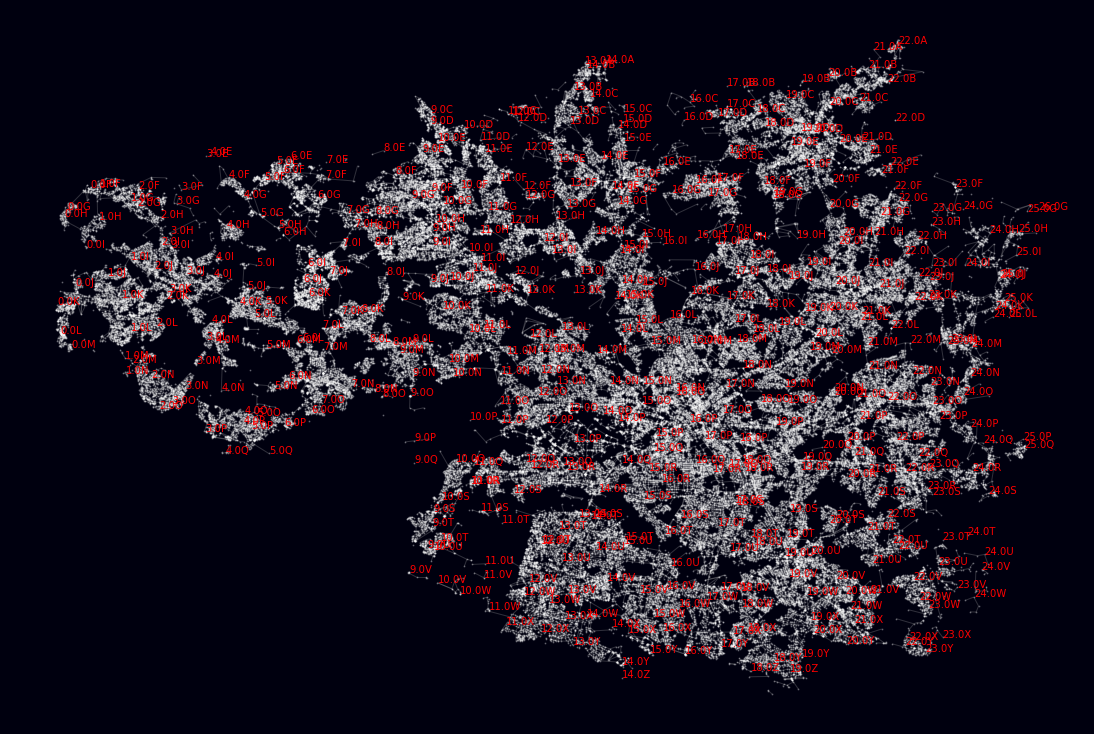

In [28]:
fig = plt.figure(figsize=(15,10))

for i in grid_refs:
    pos=nx.get_node_attributes(subgraphs[i],'pos')
    nx.draw(subgraphs[i], pos, node_size=1, node_color='white', edge_color='silver', alpha = 0.25)
    pos = list(pos.values())[0]
    x = pos[0]
    y = pos[1]
    plt.text(x,y, i, color = 'red', fontsize = 10)
fig.set_facecolor("#00000F")

In [29]:
# empty graph to populate areas of city with no road network
gg = nx.Graph()

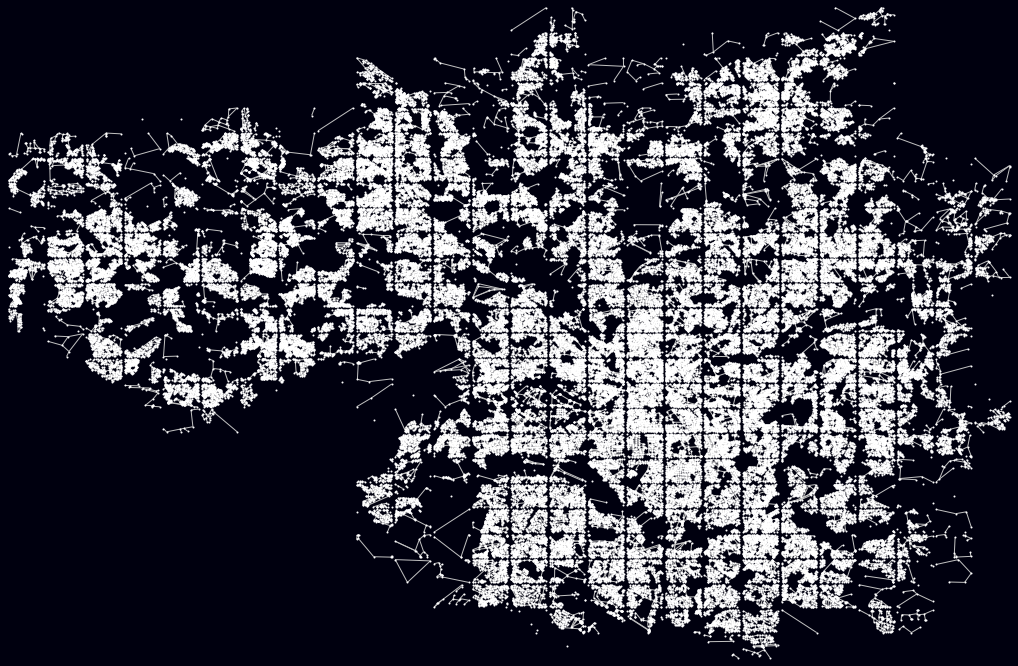

In [30]:
fig, axes = plt.subplots(nrows=100, ncols=100, figsize=(18,12))
fig.subplots_adjust(hspace =.001, wspace=.001)
ax = axes.flatten()
i=0

for i,j in enumerate(all_grid_refs):
    if j in grid_refs:
        pos = nx.get_node_attributes(subgraphs[j],'pos')
        nx.draw(subgraphs[j], pos, node_size=1, node_color='white', edge_color='silver', ax=ax[i])
        ax[i].set_axis_off()
        i+=1
        fig.set_facecolor("#00000F")
    else:
        nx.draw(gg, ax=ax[i])
        ax[i].set_axis_off()
        fig.set_facecolor("#00000F")
        i+=1

plt.show()

In [31]:
fig = plt.figure()
pos = nx.get_node_attributes(subgraphs["5.0Q"],'pos')
nx.draw(subgraphs["5.0Q"], node_size=1, node_color='white', edge_color='silver')
fig.set_facecolor("#00000F")

In [32]:
A = nx.adjacency_matrix(subgraphs['20.0X'])

In [33]:
print(A.todense())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
